In [1]:
input_dim = 4
num_clusters = 4

import numpy as np
import os
from sklearn.cluster import KMeans

import sys
sys.path.insert(0, "../Code/")
from base import load_encoder
from explain_cs import explain, apply
from metrics import metrics, eval_epsilon
from plot import plot_groups, plot_metrics
from train_ae import train_ae

def load_model(input_dim = input_dim, model_file = "/home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt"):
    return load_encoder(input_dim, model_file, encoder_shape = [20, 2])


In [2]:
# Configure the data generation process and train the autoencoder

def gen(n = 400):
    
    x = np.zeros((n, 4))
    
    for i in range(n):
        
        if np.random.uniform() < 0.5:
            x[i, 0] = 1.0 + np.random.normal(loc = 0.0, scale = 0.2)
            
        if np.random.uniform() < 0.5:
            x[i, 1] = 1.0 + np.random.normal(loc = 0.0, scale = 0.2)
            
        x[i, 2] = np.random.normal(loc = 0.0, scale = 0.5)
        
        x[i, 3] = x[i, 0] + np.random.normal(loc = 0.0, scale = 0.05)
        
    return x

x = gen()

os.system("rm -rf Model")

train_ae(x, encoder_shape = [20, 2], decoder_shape = [2, 20])


INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Mo

In [3]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})


In [4]:
# Cluster Points to define the groups

kmeans = KMeans(n_clusters = num_clusters).fit(data_rep)


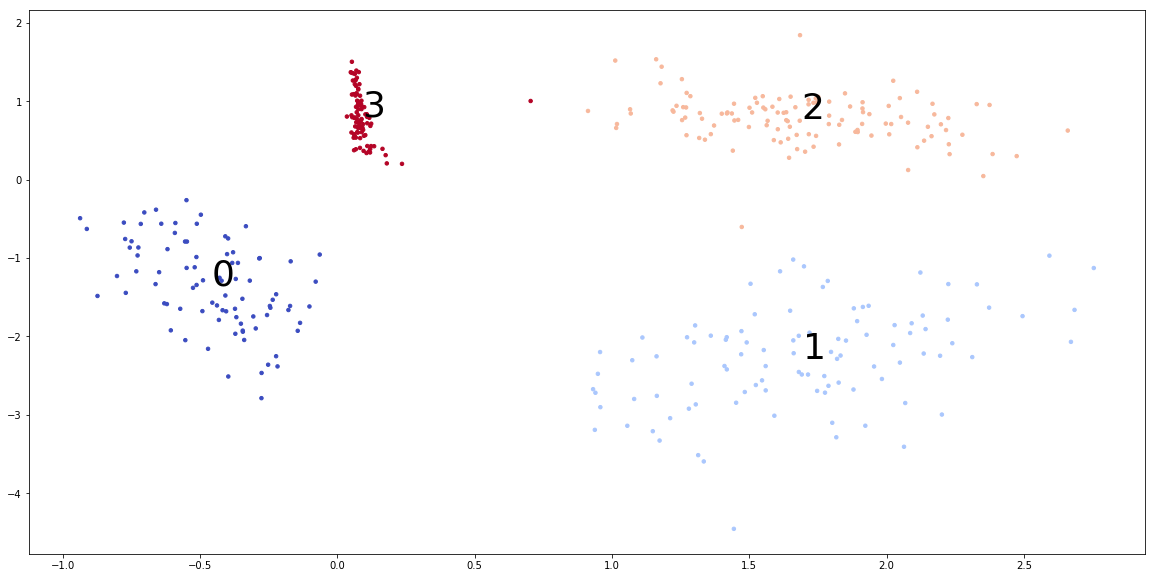

In [5]:
# Visualize the clusters in the learned representation

means, centers, indices = plot_groups(x, data_rep, num_clusters, kmeans.labels_, name = "synth-rep.png")
 

In [6]:
# Set epsilon for our metrics
epsilon = 0.5

if True:
    eval_epsilon(load_model, x, indices, epsilon)


In [7]:
# Compute the group explanations

best_val = 0.0
for i in range(5):
    deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = 1.0)
    a, b = metrics(load_model, x, indices, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas.npy", deltas)
    
    os.system("rm -rf explanation")


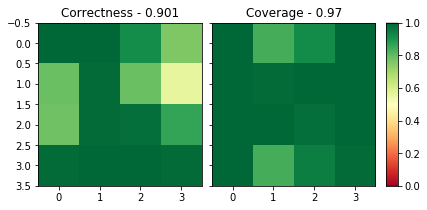

In [8]:
# Evaluate the explanations

deltas = np.load("deltas.npy")

a, b = metrics(load_model, x, indices, deltas, epsilon)

plot_metrics(a, b, name = "synth-metrics-ours.png")

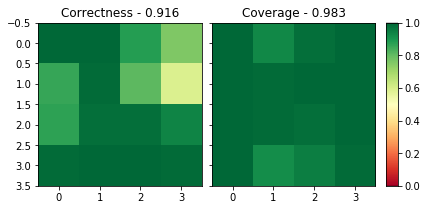

In [9]:
# Visualize the mean difference

exp_mean = np.zeros((num_clusters - 1, input_dim))
for i in range(num_clusters - 1):
    exp_mean[i, :] = means[i + 1] - means[0]
    
a, b = metrics(load_model, x, indices, exp_mean, epsilon)

plot_metrics(a, b, name = "synth-metrics-means.png")


In [10]:
# Configure the explanations for easy tabularization

exps_out = []
for i in range(num_clusters - 1):
    exps_out.append(deltas[i])
    exps_out.append(exp_mean[i])
exps_out = np.array(exps_out)   
np.savetxt("exps_out.csv", exps_out, delimiter=",", fmt = '%10.3f')
